# Fit file visualisation for running

In [1]:
import fitdecode
import pandas as pd
import seaborn
import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import LinearAxis, ColumnDataSource, Legend
from bokeh.models.ranges import Range1d
from bokeh.models.tools import HoverTool
from bokeh.palettes import Spectral4, Set1, Category10, Category20c, viridis
import colorcet as cc
%matplotlib inline

In [2]:
output_notebook()

Loading BokehJS ...

## Read FIT file

In [3]:
%%time

#src_file = "C:\\Users\meclijda\Downloads\\4977334342.fit"
src_file = "C:\\Users\meclijda\Downloads\\5039632611.fit"

with fitdecode.FitReader(src_file) as fit:
    data = []
    recordcounter = 1
    for frame in fit:
        # The yielded frame object is of one of the following types:
        # * fitdecode.FitHeader
        # * fitdecode.FitDefinitionMessage
        # * fitdecode.FitDataMessage
        # * fitdecode.FitCRC

        if isinstance(frame, fitdecode.FitDataMessage):
            # Here, frame is a FitDataMessage object.
            # A FitDataMessage object contains decoded values that
            # are directly usable in your script logic.
            #print(frame.name, recordcounter, [x.name for x in frame.fields])
            if (frame.name == "record"):
                rowdict = {}
                recordcounter += 1
                for field in frame.fields:
                    rowdict[str(field.name)+"_"+str(field.units)] = field.value
                    #print("  ",field.name,field.value,field.raw_value,field.units)
                    data.append(rowdict)
                #print(rowdict)
    df = pd.DataFrame(data)

Wall time: 303 ms


In [4]:
df.head()

,timestamp_None,position_lat_semicircles,position_long_semicircles,distance_m,enhanced_altitude_m,altitude_m,enhanced_speed_m/s,speed_m/s,heart_rate_bpm
0,2020-06-04 16:02:34+00:00,607307690,55517864,0.77,10103.8,10103.8,0.0,0.0,52
1,2020-06-04 16:02:34+00:00,607307690,55517864,0.77,10103.8,10103.8,0.0,0.0,52
2,2020-06-04 16:02:34+00:00,607307690,55517864,0.77,10103.8,10103.8,0.0,0.0,52
3,2020-06-04 16:02:34+00:00,607307690,55517864,0.77,10103.8,10103.8,0.0,0.0,52
4,2020-06-04 16:02:34+00:00,607307690,55517864,0.77,10103.8,10103.8,0.0,0.0,52


## Preprocess training data

In [5]:
df.drop_duplicates(inplace=True)
#df.reset_index(inplace=True)
df['datetime'] = pd.to_datetime(df['timestamp_None'])
df.set_index('datetime',inplace=True)
df['speed_km/h'] = df['speed_m/s']*3.6
df['distance_km'] = df['distance_m']/1000
df['position_lat_degrees'] = df['position_lat_semicircles']*180/(2**31)
df['position_long_degrees'] = df['position_long_semicircles']*180/(2**31)

df['coordinates'] = list(zip(df['position_lat_degrees'],df['position_long_degrees']))

min_alt = df['altitude_m'].min()
max_alt = df['altitude_m'].max()
std_alt = df['altitude_m'].std()
df['cor_altitude_m'] = df['altitude_m']-min(min_alt,0)

step=1
km_marker_range = range(0,int(df['distance_km'].max())+step,step)

km_markers = []
for marker in km_marker_range:
    id = abs(df['distance_km']-marker).idxmin()
    km_markers.append(df['coordinates'].loc[id])


In [6]:
#outlier detection
import numpy as np
from scipy import stats
#(np.abs(stats.zscore(df)) < 3).all(axis=1)
df = df[(np.abs(df.position_lat_degrees-df.position_lat_degrees.mean()) <= (3*df.position_lat_degrees.std()))]
df = df[(np.abs(df['cor_altitude_m']-df['cor_altitude_m'].mean()) <= (3*df['cor_altitude_m'].std()))]
df = df[(np.abs(df['speed_km/h']-df['speed_km/h'].mean()) <= (3*df['speed_km/h'].std()))]

df.describe()

,position_lat_semicircles,position_long_semicircles,distance_m,enhanced_altitude_m,altitude_m,enhanced_speed_m/s,speed_m/s,heart_rate_bpm,speed_km/h,distance_km,position_lat_degrees,position_long_degrees,cor_altitude_m
count,7.530000e+02,7.530000e+02,753.000000,7.530000e+02,7.530000e+02,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000,7.530000e+02
mean,6.074747e+08,5.529381e+07,6101.870398,9.155400e+03,9.155400e+03,3.395304,3.395304,143.257636,12.223095,6.101870,50.917938,4.634673,9.155400e+03
std,1.116253e+05,1.433386e+05,3534.306680,1.055715e-10,1.055715e-10,0.247886,0.247886,7.278102,0.892391,3.534307,0.009356,0.012015,1.055715e-10
min,6.072874e+08,5.507450e+07,40.110000,9.155400e+03,9.155400e+03,2.692000,2.692000,51.000000,9.691200,0.040110,50.902245,4.616291,9.155400e+03
25%,6.073917e+08,5.516531e+07,3063.920000,9.155400e+03,9.155400e+03,3.255000,3.255000,142.000000,11.718000,3.063920,50.910983,4.623903,9.155400e+03
50%,6.074794e+08,5.528840e+07,6050.580000,9.155400e+03,9.155400e+03,3.367000,3.367000,143.000000,12.121200,6.050580,50.918338,4.634220,9.155400e+03
75%,6.075544e+08,5.541071e+07,9135.790000,9.155400e+03,9.155400e+03,3.483000,3.483000,145.000000,12.538800,9.135790,50.924618,4.644472,9.155400e+03
max,6.076861e+08,5.555671e+07,12020.760000,9.155400e+03,9.155400e+03,4.471000,4.471000,157.000000,16.095600,12.020760,50.935664,4.656710,9.155400e+03


## Visualize training data
* first with Seaborn
* Second with Bokeh

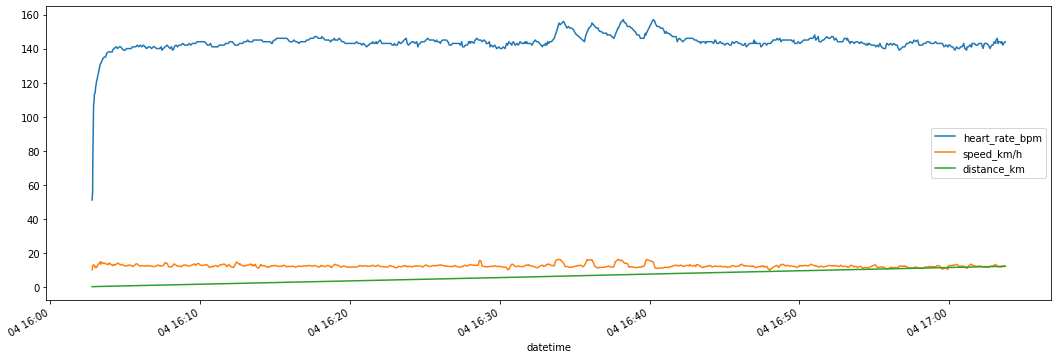

In [7]:
%matplotlib inline
df[['heart_rate_bpm','speed_km/h','distance_km']].plot(figsize=(18,6))

In [8]:
# Transform pandas dataframe into ColumnDataSource for easy plotting
source = ColumnDataSource(df[['distance_km','cor_altitude_m','heart_rate_bpm','speed_km/h']])

# Generate the general figure
p = figure(x_axis_type="linear", title="training data", plot_height=350, plot_width=900,toolbar_location="below")
p.xgrid.grid_line_color=None
p.ygrid.grid_line_alpha=0.5
p.xaxis.axis_label = 'Distance'
p.yaxis.axis_label = 'Value'

# Add secondary axis for speed
p.extra_y_ranges = {"Speed km/h": Range1d(start=df['speed_km/h'].min(), end=df['speed_km/h'].max())}
p.add_layout(LinearAxis(y_range_name="Speed km/h"), 'right')

# Add 3 line plots and 1 vertical area plot to the figure
cp = Category10[3]
l1 = p.line(x='distance_km', y='heart_rate_bpm',line_color=cp[0],line_width=2,source=source)
l2 = p.line(x='distance_km', y='speed_km/h',line_color=cp[1],source=source,y_range_name="Speed km/h")
#l3 = p.line(x='distance_km', y='cadence_rpm',line_color=cp[2],source=source)
#l4 = p.varea(x="distance_km", y1=0, y2="cor_altitude_m", alpha=0.2, fill_color='black', source=source)

# Create a clickable legend outside the figure area
l = Legend(items=[('Heart rate',[l1]),('Speed',[l2])])#,('Altitude',[l4])])
l.click_policy="hide"
p.add_layout(l, 'right')

# Add a hovertool to display detailed data
p.add_tools(HoverTool(tooltips=[('distance (km)','@distance_km{1.11}'),
                                ('heart rate (bpm)','@heart_rate_bpm'),
                                ('speed (km/h)','@{speed_km/h}{0.0}'),
                                ('altitude (m)','@cor_altitude_m{1.11}')],mode='vline'))
show(p)

## Visualize Geo data

In [9]:
import folium
from folium import plugins

In [10]:
points = df[(np.abs(df.position_lat_degrees-df.position_lat_degrees.mean()) <= (3*df.position_lat_degrees.std()))]['coordinates'].values.tolist()
ave_lat = sum(p[0] for p in points)/len(points)
ave_lon = sum(p[1] for p in points)/len(points)
 
# Load map centred on average coordinates
my_map = folium.Map(location=[ave_lat, ave_lon],zoom_start=13)

# add Markers
i=0
#cm = Category20c[len(km_markers)]
#cm = viridis(len(km_markers))
cm = list(reversed(cc.b_linear_blue_5_95_c73[:200]))
f = (len(cm))/len(km_markers)
colors= []
for km_marker in km_markers:
    cmid = int(i*f)
    colors.append(cm[cmid])
    icon_number = plugins.BeautifyIcon(
        border_color=cm[cmid], #'#00ABDC',
        text_color=cm[cmid], #'#00ABDC',
        number=i*step,
        #icon_shape='marker',
        inner_icon_style='margin:0 auto;')
    #ic = folium.Icon(icon="bicycle",prefix="fa",color="green",text="km" + str(i*step) + "")
    #ic = folium.features.DivIcon(html="<p style='color: blue'>km</br><b>" + str(i*10) + "</b></p>", icon_size=10, icon_anchor=None, popup_anchor=None, class_name='empty')
    pu = folium.map.Popup(html="<p>km</br><b>" + str(i*step) + "</b></p>", parse_html=False, max_width='50%', show=False, sticky=False)
    folium.Marker(km_marker,popup=pu,icon=icon_number).add_to(my_map)
    i=i+1
    
#fadd lines
#folium.PolyLine(points, color="blue", weight=2.5, opacity=1).add_to(my_map)
folium.features.ColorLine(points, colors= range(len(points)-1),colormap=cm, weight=2.5, opacity=1).add_to(my_map)
my_map

## Visualize times per kilometer

In [11]:
df1 = df.groupby(df['distance_km'].astype(int)).agg({'distance_km': [('distmin',np.min),('distmax',np.max),'idxmin','idxmax',('km_time', lambda x: ((x.idxmax() - x.idxmin()).total_seconds()/(x.max()-x.min())))]})['distance_km','km_time']
#df1

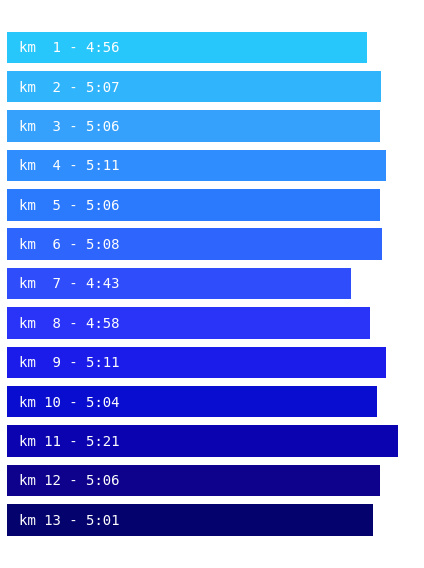

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator

def format_func(x,pos):
    hours = int(x//3600)
    minutes = int((x%3600)//60)
    seconds = int(x%60)

    return "{:d}:{:02d}".format(minutes, seconds)
    #return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds)

formatter = FuncFormatter(format_func)

f = plt.figure(figsize=(6,8))
ax = f.add_subplot(1,1,1)
ax.barh(df1.index,df1.values,color=colors)

ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(base=60))
ax.yaxis.set_major_locator(MultipleLocator(base=1))
plt.gca().invert_yaxis()

for i, (v,vr) in enumerate(zip(df1.index, df1.values)):
    plt.text(s="km "+" "*(2-len(str(i+1)))+str(v+1)+" - "+str(format_func(vr,0)), x=10, y=i, color="w", verticalalignment="center", size=14, family="monospace")

plt.axis("off")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
